# "The Johnson-Lindenstrauss lemma & Linformer"
> "Ever get the feeling that your dataset of 1000 objets in 10<sup>4</sup> dimensions (1000 RGB 192 * 192 images, let's say) might be represented by something easier to work with? Who needs that many dimensions anyway? Well we've got the right tool for you: the Johnson-Lindenstrauss lemma. This post will start with a few reminders of high-dimensional geometry, then move on to the JL lemma, and will finish by describing a recent Transformer variant, the [Linformer](https://arxiv.org/pdf/2006.04768.pdf), that takes advantage of this lemma to bypass the quadratic sequence length complexity of standard Transformers."

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/JL_linformer/equator_concentration.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# The Johnson-Lindenstrauss lemma & Linformer

Ever get the feeling that your dataset of 1000 objets in 10<sup>4</sup> dimensions (1000 RGB 192 * 192 images, let's say) might be represented by something easier to work with? Who needs that many dimensions anyway? Well we've got the right tool for you: the Johnson-Lindenstrauss lemma. This post will start with a few reminders of high-dimensional geometry, then move on to the JL lemma, and will finish by describing a recent Transformer variant, the [Linformer](https://arxiv.org/pdf/2006.04768.pdf), that takes advantage of this lemma to bypass the quadratic sequence length complexity of standard Transformers.


## 1. A bit of high-dimensional geometry

This section will be an intro to the phenomenon of concentration of measure, with examples on high-dimensional spheres: the spherical shell of multivariate Gaussians and the equator concentration. If the math scares you, you can jump ahead to the next sub-section for visual explanations. If you're already familiar with this material, feel free to skip to the next section!

### 1.1. Concentration of measure

Let's start with a set $n$ of random 1-dimensional variables $X_{1}, ... , X_{n}$. with bounded mean and variance. If every variable has a $O(1)$ standard deviation and we know nothing more about them, their sum $S_n$ might have a $O(n)$ standard deviation. Now we know, thanks to the central limit theorem, that when the variables are i.i.d., their mean will have a $O(n^{-1/2})$ standard deviation and their sum will have a $O(n^{1/2})$ standard deviation, which is much better: the sum will be much more reliably close to the typical value. Concentration of measure is a general principle to bound those fluctuations. Essentially, if $f$ is a Lipschitz function (i.e. well-behaved, gently varying) and $X_{1}, ... , X_{n}$ are not too correlated, $f(X_{1}, ... , X_{n})$ does not stray very far from its mean. If $n$ is big enough, one might as well take $f$ to be constant - it will almost always be equal to the typical value! Another famous incarnation of that principle, for independent variables $X_{1}, ... , X_{n}$ is the Chernoff inequality:

${\bf P}( |S_n - \mu| \geq \lambda \sigma ) \leq C \max( \exp( - c \lambda^2 ), \exp( - c \lambda \sigma / K ))$.

Where $\mu$ is the sum of the means of the $X_{1...n}$, K a bound on the $|X_{1...n}|$, $\sigma^2$ is the sum of the variances of the $X_{1...n}$, and $\lambda$ can be chosen arbitrarily to represent the deviation from the mean: the bigger the deviation, the more unlikely it is to happen, decreasing exponentionally. Concentration of measure is also a workhorse of statistical physics, as it provides rigorous estimations for the (un-)likelihood of fluctuations of macroscopic quantities over large sets of particles. Now let's visualize this phenomenon with two examples on the sphere.

### 1.2. Shell of multivariate Gaussians

Let's say we have a multivariate Gaussian $N(0, I_n)$. If we draw samples from it, they're going to be close to the mean of the distribution, the origin, right? Well that's only really true in low dimensions. The norm $||X||_2$ of a sample $X$ is a Lipschitz function of its coordinates $x_i$ so, thanks to concentration of mass, it is going to always be nearly the same for high enough n. This means that realizations aren't going to be close to the origin; they're going to be on a narrow shell surrounding a sphere. Let's visualize that quickly by sampling Gaussians in various dimensions and counting, for each dimension, how many samples have their norm deviate from the mean by more than 5%.

<Figure size 432x288 with 0 Axes>

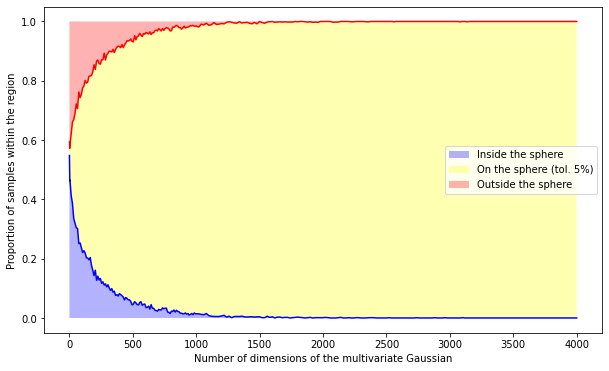

In [2]:
#collapse
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

plt.clf()
fig = plt.figure(figsize=(10, 6))

# initial set-up
inter_dim = 1000
max_dim = 4000
tolerance = 0.05
tries = 1000
dimensions = list(range(1, 5)) + list(range(5, inter_dim, 10)) + list(range(inter_dim, max_dim + 1, 20))
n_over = np.zeros(len(dimensions))
n_under = np.zeros(len(dimensions))

# let's draw a ton of 1D normal realizations!
draws = np.random.normal(0, 1, size=tries * sum(dimensions))

current_index = 0
for i, dimension in enumerate(dimensions):
  # we arrange the previous 1D draws into vectors
  samples = draws[tries*current_index:tries*(current_index + dimension)]
  samples = np.reshape(samples, (tries, dimension))
  # then just count the vectors falling inside or outside the sphere with tolerance 5%
  norms = np.linalg.norm(samples, 2, axis=1)
  deviations = (norms / np.mean(norms) - 1)
  n_over[i] = np.count_nonzero(deviations > tolerance) / tries
  n_under[i] = np.count_nonzero(deviations < -tolerance) / tries
  current_index += dimension

plt.fill_between(dimensions, 0, n_under, facecolor='blue', alpha=0.3)
plt.fill_between(dimensions, n_under, 1 - n_over, facecolor='yellow', alpha=0.3)
plt.fill_between(dimensions, 1 - n_over, 1, facecolor='red', alpha=0.3)
plt.xlabel("Number of dimensions of the multivariate Gaussian")
plt.ylabel("Proportion of samples within the region")
plt.legend(("Inside the sphere", "On the sphere (tol. 5%)", "Outside the sphere"), loc="best")
plt.plot(dimensions, 1 - n_over, color='red')
plt.plot(dimensions, n_under, color='blue')

At high dimensions, our intuition that the mode of the distribution is a typical value is wrong. The probability of a sample being close to the average is infinitesimal. Instead, samples are all close to a sphere. This has entered popular science under the name of flaw of averages: designing a plane for the [average pilot](https://www.thestar.com/news/insight/2016/01/16/when-us-air-force-discovered-the-flaw-of-averages.html), for example, will fit nearly no one.

### 1.3. Concentration at the equator

Another related phenomenon that's useful in concentration of measure proofs is the density of equators. Let's take a 3-dimensional sphere. If we choose an equator on it, most points aren't going to be particularly close to it: unfortunately for those of us who like warm seas, the tropical part of Earth only constitutes 40% of its surface. Let's draw samples on a spheres on increasing dimensionality and see if that's still the case! For spheres of increasing dimension, we're going to draw 1000 points uniformly chosen on the surface, Then, we'll organize those points by latitude (the angle difference to the equator, same as on Earth).

<Figure size 432x288 with 0 Axes>

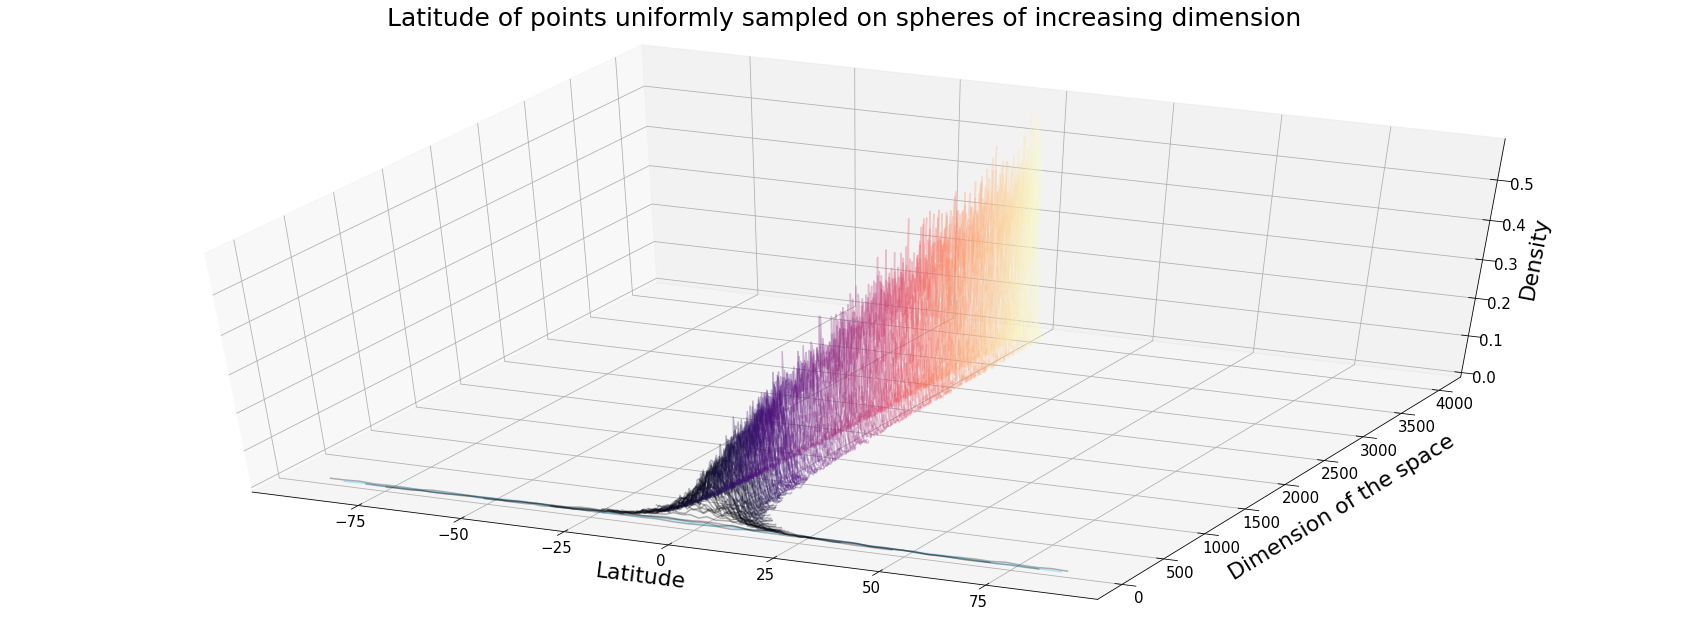

In [12]:
#collapse
from matplotlib import colors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.clf()

fig = plt.figure(figsize=(30, 11))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -65)

bins = tries // 20

def latitudes(points):
    return np.degrees(np.arcsin(points[:, 0]))

def lighten(rgb, white_amount):
  return ((white_amount + rgb[0]) / (1 + white_amount), (white_amount + rgb[1]) / (1 + white_amount), (white_amount + rgb[2]) / (1 + white_amount), rgb[3])

current_index = 0
cmap = plt.get_cmap('magma') 
norm  = colors.Normalize(vmin=min(dimensions), vmax=max(dimensions))
scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
ax.set_xlabel("Latitude", fontsize=22, labelpad=20)
ax.set_ylabel("Dimension of the space", fontsize=22, labelpad=20)
ax.set_zlabel("Density", fontsize=22, labelpad=5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title("Latitude of points uniformly sampled on spheres of increasing dimension", fontsize=25, pad=50)
for i, dimension in enumerate(dimensions[1:]):
  # we arrange the previous 1D draws into vectors
  samples = draws[tries*current_index:tries*(current_index + dimension)]
  samples = np.reshape(samples, (tries, dimension))
  # then project them on the unit sphere
  norms = np.linalg.norm(samples, 2, axis=1)
  samples_on_sphere = samples / norms[:, None]
  sorted_latitudes = np.sort(latitudes(samples_on_sphere))
  histogram, bin_edges = np.histogram(sorted_latitudes, bins=bins, density=True)
  bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
  color = scalar_map.to_rgba(dimension)
  dimension_array = np.array([dimension] * bins)
  if dimension == 3:
    color = "deepskyblue"
  rgb = colors.to_rgba(color)
  white_amount = 5
  lighter = lighten(rgb, white_amount)
  # ax.add_collection3d(Poly3DCollection([list(zip(bin_centers, dimension_array, histogram)) + [(bin_centers[-1], dimension, 0), (bin_centers[0], dimension, 0)]], color=lighter, alpha=1)) 
  plt.plot(bin_centers, dimension_array, histogram, color=color, alpha=0.3)

Very quickly, the distribution becomes extremely peaky at 0: all of the points are close to the equator. In usual concentration-of-measure fashion, if you choose a certain tolerance around the equator (say, between the tropics), the amount of measure outside that band decreases in an exponential function of the dimension. The really fun part is that, by rotational symmetry, whatever equator you choose, this is still true! Every equator is dense on a 4000-dimensional sphere. In a sense, this is less a result about equators than a result about distances. On a high-dimensional sphere, points are much closer together and our intuition about distances breaks down. Our own 3-dimensional Earth, approximated as a sphere, is the thin blue line at the start. Maybe we should move to a 100-dimensional planet - then everyone could live under the tropics (latitude 23 degrees).


## 2. The Johnson-Lindenstrauss lemma

Now that we have a bit of intuition about high-dimensional geometry, let's move on to the JL lemma!

### 2.1. Claim 

The Johnson-Lindenstrauss lemma makes two main claims:

*   If you have a set $P$ of $p$ points in $\mathbb{R}^{n}$ and a certain error tolerance $\epsilon$, there exists a smaller dimension $k \sim 8 * log(n) / \epsilon^{2} $ and a projection function $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{k}$ such that the geometry of $f(P)$ matches the geometry of $P$ with tolerance $\epsilon$: $\forall x, y \in P, (1-\epsilon) < \frac{||f(y) - f(x)||_{2}}{||y - x||_{2}} < (1 + \epsilon)$.
*   One can find a suitable function in polynomial random time in $n$ simply by trying random orthogonal projections from $\mathbb{R}^{n}$ to $\mathbb{R}^{k}$.

This gives us a very practical weapon to do dimensionality reduction: it has only a logarithmic dependency in the dataset size, which doesn't depend on the dimension of the original space, and an easy way to find the right projection is conveniently provided. 

### 2.2 Elements of proof

The lemma is intimately connected to concentration of measure effects. Here's a very broad outline of a proof to get some intuition into it:

*   First, observe that if the projection $f$ is linear, **we can restrict ourselves to vectors on the unit sphere.** Those will represent the normalized differences between the vectors of the dataset: if $x, y \in P$ and $v := \frac{y - x}{||y - x||}$, then $||f(v)|| = \frac{||f(y) - f(x)||}{||y - x||}$, so if we can show that $||f(v)|| \approx ||v|| = 1$ $\forall v \in S^n$, we've won: in this case, $||f(y) - f(x)|| \approx ||y - x||$ $\forall x, y \in P$.
*   **Since both taking the norm and the projection $f$ are Lipschitz, we have access to a concentration of measure result.** Here, for k large enough as a function of n (a logarithmic function suffices), the norm of the result $||f(v)||$ is very unlikely ($O(n^{-2})$) to diverge from the expected result, 1, by more than $\epsilon$.
*   Now we know random orthogonal projections from $\mathbb{R}^{n}$ to $\mathbb{R}^{k}$ are very unlikely ($O(n^{-2})$) to change the norm of a unit vector. Thanks to the union bound, that means **they're still unlikely ($O(n^{-1})$) to change the norm of any of the $n$ vectors by more than $\epsilon$**.
* Since random orthogonal projections from $\mathbb{R}^{n}$ to $\mathbb{R}^{k}$ have a high (bigger than $\frac{1}{2}$ would suffice) likelihood of satisfying the lemma, **we can just keep trying random projections until one fits**.

For a rigorous proof, I personally found [Dasgupta and Gupta's proof](https://cseweb.ucsd.edu/~dasgupta/papers/jl.pdf) the easiest to go through.

### 2.3 The unreasonable effectiveness of random orthogonal projections

Essentially what makes the whole machinery work is that random orthogonal projections are very good at preserving data structure. This ties back to the previous observations about sphere equators. Let's say our data is distributed on a sphere, and we project it onto a hyperplane. Which are the points that hurt and the points that do well?

![](https://drive.google.com/uc?export=view&id=1mkw56UNhQPHlSXsYv7EpbUGfEb2Kqrxa)

The points next to the equator keep the same structure: if they were far apart before, they're far apart afterwards, and reciprocally. It's the poles that are a problem. Luckily, we know that in high enough dimension, whatever equator we choose, the points are going to be concentrated next to it! So after randomly projecting, the data will have kept the same structure. This is something that shows up time and again in machine learning: **random projections are unreasonably effective.** Back when SVMs were the state-of-the-art, in the 2000s, [Random kitchen sinks](http://www.argmin.net/2017/12/05/kitchen-sinks/) had already made the same observation. Is your dataset too high-dimensional to compute what you want? Just run it through a random projection to a low-dimensional space and it'll be fine.

## 3. Linformer

Now that we're armed with weapons of mass dimensionality reduction, how can we use them to make a better Transformer? Now the secret is that we won't use them to compress the embedding dimension $d$ as usual, but rather the sequence length $n$.

### 3.1. Reducing the context mapping

Let's take a moment to recall how attention works. We'll stay in the single-head attention case, with $n$ the sequence length and $d$ the embedding dimension. Let's say we have 3 inputs: embedding matrices $Q, K, V \in \mathbb{R}^{n \times d}$, and 3 learned matrices $W_Q, W_K, W_V \in \mathbb{R}^{d \times d}$. We then have $Attention(Q, K, V) = softmax(\frac{QW^Q(KW^K)^T}{\sqrt d})VW^V = PVW^V$.

Now the issue here is $P$. $P \in \mathbb{R}^{n \times n}$; it scales quadratically with the sequence length. Linformer makes the observation that usually, **P doesn't actually contain $n^2$ worth of information**. A few of its eigenvalues completely dominate the others: if we only kept them and set the others to $0$, we'd have a good approximation for cheap.

![](https://drive.google.com/uc?export=view&id=1RwHtNQda7JplS3krgCOY1ewHKko9FTQA)

*(From [Linformer](https://arxiv.org/pdf/2006.04768.pdf))*

For comparison, random matrices tend to follow very tight eigenvalue distributions, with no special emphasis on a few eigenvalues that dominate the others. Here's Girko's circular law for matrices with Gaussian entries:

![](https://drive.google.com/uc?export=view&id=1rQCx-6ywkZxErIAlM1vZ3FZf-zVrkDpg)

*(From [Wolfram Mathworld](https://mathworld.wolfram.com/GirkosCircularLaw.html))*

All of the eigenvalues coexist in a tight disk around the origin! Hard to imagine a few eigenvalues running away with most of the weight in those conditions. Now the issue is that we can't really use eigenvalue decomposition to reduce the computational footprint of $P$; for starters, every time we compute $P$, the eigenvalues and eigenvectors will be different, so we'd actually lose time going through the process for every attention head at every forward pass. Instead, **we're going to project $KW^K$ and $VW^V$ into a smaller space**: instead of being in $\mathbb{R}^{n \times d}$, they'll be **in $\mathbb{R}^{k \times d}$ with k suitably chosen thanks to Johnson-Lindenstrauss and the low-rank properties of $P$**. Essentially, when asking a query $Q$, the attention module will not look individually at each token as with the full $P$, but at a compressed representation $P'$ that fuses the key and values together into $k$ items rather than the full $n$.

###3.2. In practice

The paper gives two theoretical results to support itself. The first is an immediate use of the Johnson-Lindenstrauss lemma to prove that $P$ can be approximated by an easy-to-find low-rank matrix. Although it claims that "self-attention is low-rank" it doesn't actually use the information that $P$ is a context matrix; it would work equally as well for any $n \times n$ matrix. The second adds that two important parts: the first is that going through the softmax afterwards doesn't break the approximation. The second is that if $P$ is low-rank, $k$ can be chosen independently of sequence length $n$. I'd argue that $P$ isn't actually low-rank but very close to one, so a rigorous theoretical analysis should account for that difference, and that its rank $r$ might probably still depends on $n$, so there is a dependency somewhere, although it is likely to be sub-logarithmic, or even in $O(log(log(n)))$. 

In any case, we're going to be using projection matrices $E, F \in \mathbb{R}^{n \times k}$ (the blue projections in the diagram below). Thanks to our theoretical guarantees, we'll be able to use $P' \in \mathbb{R}^{n \times k}$ instead of $P \in \mathbb{R}^{n \times n}$ in our calculations by taking $P' = softmax(\frac{QW^Q(EKW^K)^T}{\sqrt d})$ (notice the $E$ that's inserted itself in the middle!). We'll then match it against a projected value vector $FVW^V \in \mathbb{R}^{k \times d}$. At no moment is a $n \times n$ ever calculated. No GPUs will be hurt in the making of this experiment.

![](https://drive.google.com/uc?export=view&id=1AGFLx1b17kyDDiGbBW1AFviC7myKCgQA)

*(From [Linformer](https://arxiv.org/pdf/2006.04768.pdf))*

A pure Johnson-Lindenstrauss way would be to use random projection matrices $E$ and $F$. Instead, Linformer learns them, and more interestingly, uses parameter sharing. Indeed, using a single matrix $G$ for both the $E$ and $F$ of the entire model doesn't seem to hinder performance - which is coherent with the JL intuition that a random projection would have sufficed. In addition, $k$ is chosen as a hyperparameter rather than given by the JL lemma. In any case, making it a power of 2 helps by speeding up computation, probably more than having the perfect principled $k$.

###3.3 Results

Whether or not Linformer truly is $O(n)$, there is no question that it works *extremely well*. Here's a comparison of the evolution of validation perplexity during training compared to a standard Transformer:

![](https://drive.google.com/uc?export=view&id=14iPMjd7hVhSbbtVefVbN6pJTX8BnfgoV)

*(From [Linformer](https://arxiv.org/pdf/2006.04768.pdf))*

So basically the same. In the experiments, downstream performance was also comparable to RoBERTa's. And the speed boost at inference is quite impressive too:

![](https://drive.google.com/uc?export=view&id=1en0B2lbmTSUEX3xbyIM5S12LrTEN9o4J)

*(From [Linformer](https://arxiv.org/pdf/2006.04768.pdf))*